# Image preprocessing

In [1]:
import os
import string
import random 
import sys
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import man_augmentation as aug
# https://albumentations.readthedocs.io/en/latest/examples.html
import albumentations as alb

# Access top level module 
sys.path.append('..')
from src.engine import get_rand_name
from src.engine import color_img

%matplotlib inline
#plt.style.use('fivethirtyeight')
#plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['font.size'] = 14

In [2]:
ROOT = "../input/"

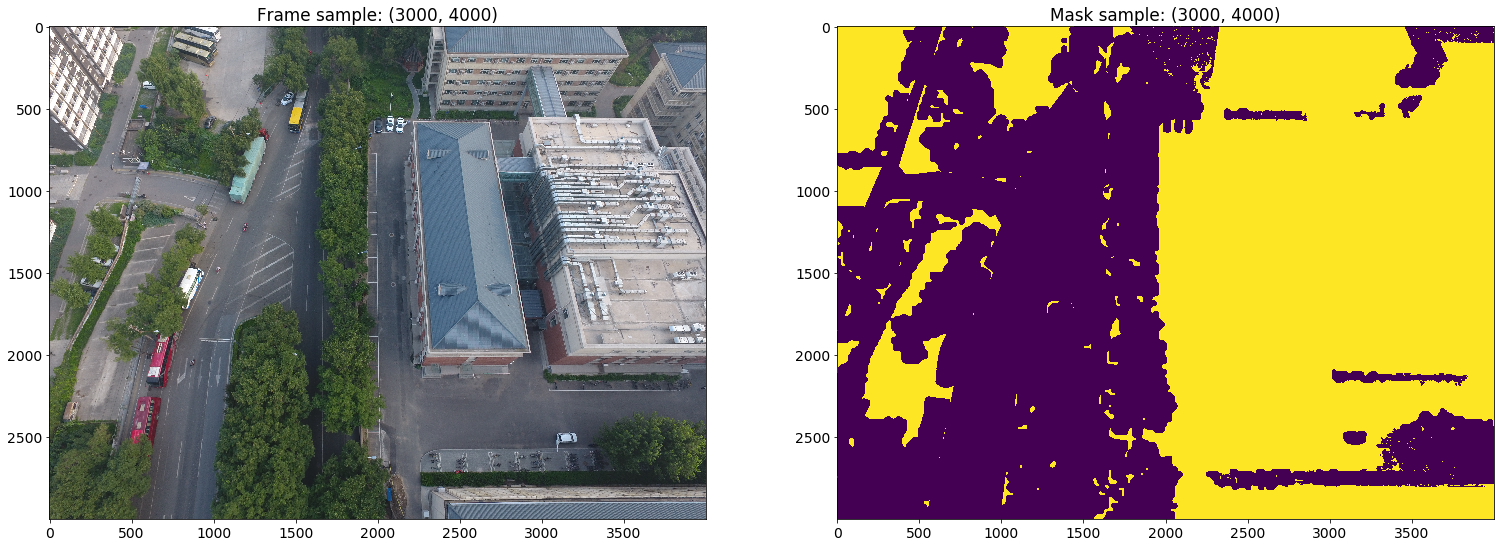

In [29]:
## Labels has been shifted from the original UDD as follow ----
# Vegetation	0	(0,255,0)	_t.png
# Building	    1	(255,0,0)	_b.png
# Road	        2	(0,0,255)	_r.png
# Vehicle	    3	(128,128,0)	_v.png
# Other	        4	(128,128,128)
# To ----
# 0 : background
# 1 : Road
# 2 : occluded_road
# 3 : vegetation
img_in_path = ROOT + 'source-dataset-udd/validation/images/'
mask_in_path = ROOT + 'source-dataset-udd/validation/mask/'

for (frame, mask) in zip(os.listdir(img_in_path), os.listdir(mask_in_path)):
    fig = plt.figure(figsize=(40,42))
    
    axs = fig.add_subplot(1,3,1)
    frame_img = plt.imread(img_in_path + frame)
    axs.set_title(f"Frame sample: ({frame_img.shape[0]}, {frame_img.shape[1]})")
    axs.imshow(frame_img)
    
    axs = fig.add_subplot(1,3,2)
    mask_img = np.array(Image.open(mask_in_path + mask))
#     mask_img = cv2.imread('source-dataset-udd/train/gt/' + fname.split(".")[0] + '.png')
    axs.set_title(f"Mask sample: ({mask_img.shape[0]}, {mask_img.shape[1]})")
    axs.imshow((mask_img[:, :] == 0))
    
    break

In [24]:
img = cv2.imread(ROOT + 'source-dataset-udd/validation/mask/DJI_0499_heda.png')

In [25]:
np.unique(img)

array([0], dtype=uint8)

In [ ]:
# Image cropping  
def apply_crop(height, width, step_h, step_w,
               frame_in_path=None, 
               mask_in_path=None,
               frame_out_path=None,
               mask_out_path=None,
               center_crop=False):
    
    if not (os.path.isdir(frame_in_path) and
            os.path.isdir(mask_in_path) and
            os.path.isdir(frame_out_path) and
            os.path.isdir(mask_out_path)):
        raise Exception(f"Failed to load one of the given path")
    if not (height and width):
        raise Exception(f"Dimension not matched ({height}, {width})")
    if not (step_h and step_w):
        raise Exception(f"Step {step_h} or {step_w} not supported")
        
    for filename in tqdm(os.listdir(frame_in_path)):
        # Load frames and masks from npy source 
        frame_in = cv2.imread(os.path.join(frame_in_path, filename))
        frame_in = cv2.imread(os.path.join(mask_in_path, filename))
#         mask_in = np.load(os.path.join(mask_in_path, filename.split('.')[0] + '.npy')) 

        for w in range(0, width, step_w):
            for h in range (0, height, step_h):
                frame_out = frame_in[h:h+step_h, w:w+step_w]
                mask_out = mask_in[h:h+step_h, w:w+step_w]
                rand_name = get_rand_name()
                cv2.imwrite(os.path.join(frame_out_path, rand_name + '.png'), frame_out)
                cv2.imwrite(os.path.join(mask_out_path, rand_name + '.png'), mask_out)

In [45]:
# Crop images & mask(npy files)

apply_crop(720, 1280, 360, 320, 
          frame_in_path=ROOT + 'source/generated-v2-01/JPEGImages/',
          mask_in_path=ROOT + 'source/generated-v2-01/SegmentationClass/', 
          frame_out_path=ROOT + 'source/sliced-v2-01/images/',
          mask_out_path=ROOT + 'source/sliced-v2-01/mask/')


## Image augmentation using Ablumentations

In [ ]:
# Augmentation using albumentation 
# https://albumentations.readthedocs.io/en/latest/examples.html
import albumentations as alb
import random 
import numpy as np

In [ ]:
def apply_augmentation(p=0.7, frame_in_path=None, mask_in_path=None, frame_out_path=None, mask_out_path=None):
    # define augmentation pipeline
    pipeline = alb.Compose([
        alb.VerticalFlip(),
        alb.HorizontalFlip(),
        alb.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=1),
        alb.ElasticTransform(border_mode=cv2.BORDER_REFLECT_101, alpha_affine=40, p=1),
        alb.OneOf([
            alb.GaussianBlur(p=0.7, blur_limit=3),
            alb.RandomRain(p=0.7, brightness_coefficient=0.6, drop_width=1, blur_value=5),
            alb.RandomSnow(p=0.7, brightness_coeff=1, snow_point_lower=0.3, snow_point_upper=0.5),
            alb.RandomShadow(p=0.6, num_shadows_lower=1, num_shadows_upper=1, 
                            shadow_dimension=5, shadow_roi=(0, 0.5, 1, 1)),
            alb.RandomFog(p=0.7, fog_coef_lower=0.7, fog_coef_upper=0.8, alpha_coef=0.1)
        ], p=0.8),
        alb.OneOf([
            alb.CLAHE(clip_limit=2),
            alb.IAASharpen(),
            alb.IAAEmboss(),
            alb.RandomBrightnessContrast(),
        ], p=0.6),
    ], p=p)
    
    # Apply pipeline for randomly picked image for 800 trial -> to generate 800 images
    for _ in range(800):
        # Shuffle out image list
        frame_list = os.listdir(frame_in_path)
        random.shuffle(frame_list)
        index = random.randint(0, len(frame_list)-1)
        # Pick one image 
        frame_id = frame_list[index]
        # Apply augmentation to the coosen image
        frame_in = cv2.imread(frame_in_path + frame_id)
        mask_in = cv2.imread(mask_in_path + frame_id)
        # Fit pipeline 
        augmented = pipeline(image = frame_in, mask = mask_in)
        # Get outcomes 
        frame_out, mask_out = augmented["image"], augmented["mask"]
        # Gen. out filename 
        f_name = get_rand_name()
        # Write file to out dir 
        cv2.imwrite(frame_out_path + f_name + '.png', frame_out)
        cv2.imwrite(mask_out_path + f_name + '.png', mask_out)

In [ ]:
# Same as above, used for experimenting unique trasnformation
def apply_augmentation_exp(p=0.9, frame_in_path=None, mask_in_path=None, frame_out_path=None, mask_out_path=None):
    # define augmentation pipeline
    pipeline = alb.Compose([
       alb.RandomRain(p=0.7, brightness_coefficient=0.6, drop_width=1, blur_value=5),
    ], p=p)
    
    # Apply pipeline for x randomly picked images
    for _ in range(20):
        # Shuffle out image list
        frame_list = os.listdir(frame_in_path)
        random.shuffle(frame_list)
        index = random.randint(0, len(frame_list)-1)
        # Pick one image 
        frame_id = frame_list[index]
        # Apply augmentation to the coosen image
        frame_in = cv2.imread(frame_in_path + frame_id)
        mask_in = cv2.imread(mask_in_path + frame_id)
        # Fit pipeline 
        augmented = pipeline(image = frame_in, mask = mask_in)
        # Get outcomes 
        frame_out, mask_out = augmented["image"], augmented["mask"]
        # Gen. out filename 
        f_name = get_rand_name()
        # Write file to out dir 
        cv2.imwrite(frame_out_path + f_name + '.png', frame_out)
        cv2.imwrite(mask_out_path + f_name + '.png', mask_out)
        
apply_augmentation_exp(p=0.9, 
                       frame_in_path=ROOT + 'source/sliced-all/images/', 
                       mask_in_path=ROOT + 'source/sliced-all/mask/', 
                       frame_out_path=ROOT + 'source/augmented-all/images/', 
                       mask_out_path=ROOT + 'source/augmented-all/mask/')

### Training score 

In [4]:
unet_scores = pd.read_csv(ROOT + "unet.csv")
bcd_scores = pd.read_csv(ROOT + "bcd-unet.csv")

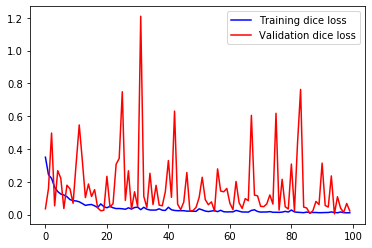

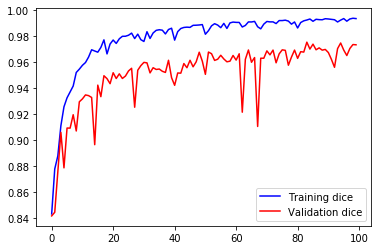

In [7]:
# Plot Loss 
plt.plot(unet_scores['loss'], 'b', label='Training dice loss')
plt.plot(unet_scores['val_loss'], 'r', label='Validation dice loss')
plt.legend()
plt.show()

# Plot Accuracy 
plt.plot(unet_scores['dice'], 'b', label='Training dice')
plt.plot(unet_scores['val_dice'], 'r', label='Validation dice')
plt.legend()
plt.show()

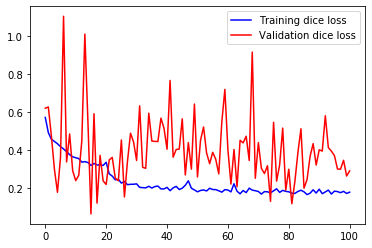

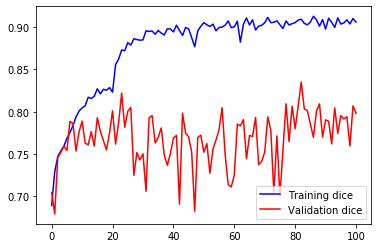

In [8]:
# Plot Loss 
plt.plot(bcd_scores['loss'], 'b', label='Training dice loss')
plt.plot(bcd_scores['val_loss'], 'r', label='Validation dice loss')
plt.legend()
plt.show()

# Plot Duce 
plt.plot(bcd_scores['dice'], 'b', label='Training dice')
plt.plot(bcd_scores['val_dice'], 'r', label='Validation dice')
plt.legend()
plt.show()

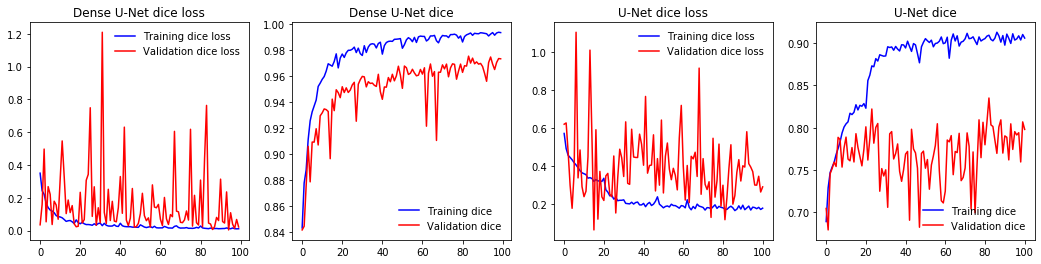

In [5]:
fig = plt.figure(figsize=(18,4))
# Dice Loss - UNET  
axs = fig.add_subplot(1, 4, 1)
axs.plot(unet_scores['loss'], 'b', label='Training dice loss')
axs.plot(unet_scores['val_loss'], 'r', label='Validation dice loss')
axs.set_title('Dense U-Net dice loss')
axs.legend(loc='upper right', frameon=False)
# Dice - UNET
axs = fig.add_subplot(1, 4, 2)
axs.plot(unet_scores['dice'], 'b', label='Training dice')
axs.plot(unet_scores['val_dice'], 'r', label='Validation dice')
axs.set_title('Dense U-Net dice')
axs.legend(loc='lower right', frameon=False)
# Dice Loss - UNET  
axs = fig.add_subplot(1, 4, 3)
axs.plot(bcd_scores['loss'], 'b', label='Training dice loss')
axs.plot(bcd_scores['val_loss'], 'r', label='Validation dice loss')
axs.set_title('U-Net dice loss')
axs.legend(loc='upper right', frameon=False)
# Dice - UNET
axs = fig.add_subplot(1, 4, 4)
axs.plot(bcd_scores['dice'], 'b', label='Training dice')
axs.plot(bcd_scores['val_dice'], 'r', label='Validation dice')
axs.set_title('U-Net dice')
axs.legend(loc='lower right', frameon=False)

Text(0.5, 1.0, 'U-Net dice')

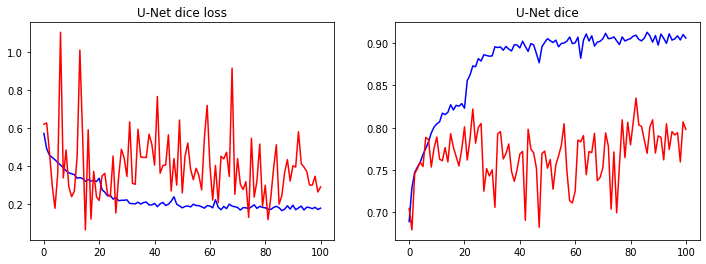

In [18]:
fig = plt.figure(figsize=(12,4))

